In [3]:
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=False)
import torch
import torch.nn  as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

Populating the interactive namespace from numpy and matplotlib


In [4]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [13]:
class net(torch.nn.Module):
  def __init__(self):
    super(net, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.drop = nn.Dropout(p=0.1, inplace=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.drop(x)
    x = self.sm(x)
    return x

In [14]:
model = net()
model 

net(
  (l1): Linear(in_features=784, out_features=128, bias=False)
  (l2): Linear(in_features=128, out_features=10, bias=False)
  (drop): Dropout(p=0.1, inplace=False)
  (sm): LogSoftmax(dim=1)
)

In [15]:
X_train.shape

(60000, 28, 28)

 loss :31.005582809448242,accuracy : 0.1171875
 loss :0.8933751583099365,accuracy : 0.765625
 loss :0.5126103162765503,accuracy : 0.8671875
 loss :0.7127403020858765,accuracy : 0.7421875
 loss :0.48519042134284973,accuracy : 0.8125
 loss :0.5153605937957764,accuracy : 0.828125
 loss :0.3382857143878937,accuracy : 0.875
 loss :0.5417469143867493,accuracy : 0.84375
 loss :0.3124518394470215,accuracy : 0.890625
 loss :0.35445985198020935,accuracy : 0.875


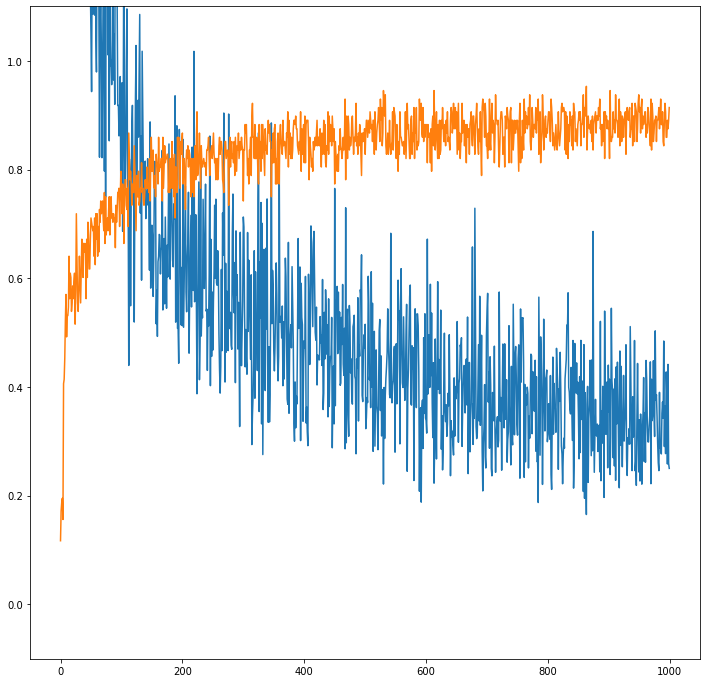

In [16]:
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
losses, accuracies = [], []
for i in range(1000):
    samp = np.random.randint(0,X_train.shape[0], size = BS)
    X = torch.tensor(X_train[samp].reshape((-1,28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    
    loss = loss_function(out, Y)
    loss = loss.mean()
    
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    if i % 100 == 0:
        print(f""" loss :{loss},accuracy : {accuracy}""")
figure(figsize = (12,12))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [18]:
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()

In [19]:
(Y_test == Y_test_preds).mean()

0.8828

In [20]:
l1 = np.zeros((784,128), dtype = np.float32)
l2 = np.zeros((128,10), dtype = np.float32)
l1[:] = model.l1.weight.detach().numpy().T
l2[:] = model.l2.weight.detach().numpy().T

In [21]:
l1.shape, l2.shape

((784, 128), (128, 10))

In [ ]:
def dropout_layer(x, dropout):
    assert 0 <= dropout <=1
    if dropout == 1:
        return np.zeros_like(x)
    mask = (np.random.uniform(0,1, size = x.shape) > dropout)
    return mask *x /(1.0 - dropout)

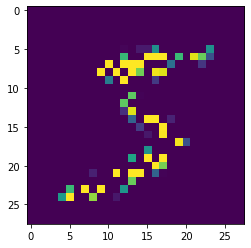

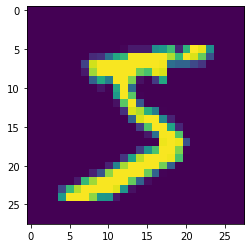

In [23]:
figure()
imshow(dropout_layer(X_train[0], 0.6))
figure()
imshow(X_train[0])

In [48]:
def forward(x):
    x = x.dot(l1)
    x = np.maximum(0,x)
    print(x)
    x = dropout_layer(x, 0.1)
    print(x)

    x = x.dot(l2)
    return x
Y_test_preds_out = forward(X_test.reshape((-1,28*28)))
Y_test_preds = np.argmax(Y_test_preds_out,axis =  1)
(Y_test == Y_test_preds).mean()

[[163.26529    55.553585   41.79695   ... 120.09964     0.
    1.8402901]
 [  0.          0.          0.        ...  48.050076   91.61946
    0.       ]
 [  0.         57.77672    86.74544   ...   0.          0.
    0.       ]
 ...
 [  0.        192.1254     18.066391  ...  11.919102    0.
    0.       ]
 [  0.          0.          6.9137344 ...   0.          0.
    0.       ]
 [  0.          0.         40.449196  ...   0.         33.03901
   43.296127 ]]
[[181.40588   61.726208   0.       ...   0.         0.         0.      ]
 [  0.         0.         0.       ...  53.388973 101.7994     0.      ]
 [  0.        64.19636   96.38382  ...   0.         0.         0.      ]
 ...
 [  0.       213.47267   20.073769 ...  13.243446   0.         0.      ]
 [  0.         0.         7.681927 ...   0.         0.         0.      ]
 [  0.         0.        44.943554 ...   0.        36.71001    0.      ]]


0.1275

(tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.5000,
           0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000]]),
 tensor(1.))

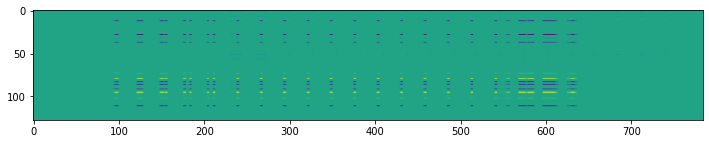

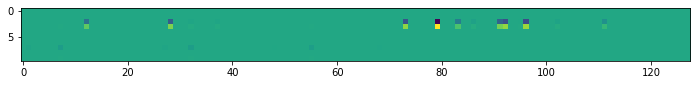

In [24]:
samp = [0,1]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape(-1,28*28)).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()
figure(figsize = (12,12))
plt.imshow(model.l1.weight.grad)
figure(figsize = (12,12))
plt.imshow(model.l2.weight.grad)
out.grad, loss.grad

In [49]:
def logsumexp(x):
    c = x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))
def dropout_layer(x, dropout):
    assert 0 <= dropout <=1
    if dropout == 1:
        return np.zeros_like(x)
    mask = (np.random.uniform(0,1, size = x.shape) > dropout)
    return mask *x /(1.0 - dropout)


def forward_backward(x,y, dropout):
    out = np.zeros((len(y),10), dtype = np.float32)
    out[range(out.shape[0]), y] = 1
    
    #forward
    
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    x_drop = dropout_layer(x_relu, 0.1)
    x_l2 = x_drop.dot(l2)
    #logsumexp
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
    #NLL loss
    x_loss =  (-out * x_lsm).mean(axis = 1)
    
    
    
    #backward
    d_out = -out/len(y)
    dsm = d_out - np.exp(x_lsm) * d_out.sum(axis=1).reshape((-1, 1))

    d_l2 = x_relu.T.dot(dsm)
    dx_drop = np.multiply( d_l2,  (np.random.uniform(0,1, size = d_l2.shape) > dropout))

    dx_relu = dsm.dot(l2.T)  
    dx_l1 = (x_relu > 0).astype(float32) * dx_relu
    d_l1 = x.T.dot(dx_l1)
    return x_loss, x_l2, d_l1, d_l2

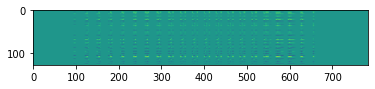

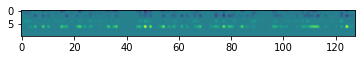

In [50]:
samp = [0,1,2,3]
x_loss, x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, 28*28)), Y_test[samp], 0.1)

imshow(d_l1.T)
figure()
imshow(d_l2.T)

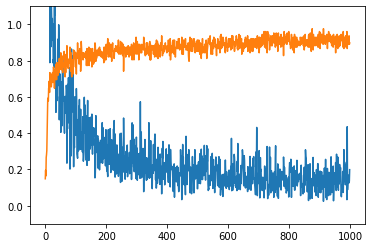

In [52]:
# training
def kaiming(m,h):
    return (np.random.randn(m,h)*math.sqrt(2./m)).astype(np.float32)

l1 = kaiming(*l1.shape)
l2 = kaiming(*l2.shape)
lr = 0.001
BS = 128
losses, accuracies = [], []
for i in range(1000):
    samp = np.random.randint(0,X_train.shape[0], size = BS)
    x_loss, x_l2, d_l1, d_l2 = forward_backward(X_train[samp].reshape((-1,28*28)), Y_train[samp],0.1)
    cat = np.argmax(x_l2, axis=1)
    accuracy = (cat == Y_train[samp]).mean()

    # SGD
    l1 = l1 - lr*d_l1
    l2 = l2 - lr*d_l2

    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)

plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [53]:
Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
(Y_test == Y_test_preds).mean()

[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         8.952977  ...  4.9718757  0.        25.899096 ]
 ...
 [ 0.        38.75322    0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]
[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         9.947753  ...  5.5243063  0.         0.       ]
 ...
 [ 0.        43.059135   0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]


0.904